**Install required tensorflow library.**

In [1]:
!pip install tensorflow tensorflow-datasets

**Import Libraries.**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds

**Load CIFAR-10 dataset.**

In [3]:
(ds_train_full, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

class_names = ds_info.features['label'].names


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.E4FMV8_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.E4FMV8_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


**Preprocessing and splitting**

In [4]:
# Preprocessing and splitting
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_size = 0.8
train_count = int(ds_info.splits['train'].num_examples * train_size)

ds_train = ds_train_full.take(train_count)
ds_val = ds_train_full.skip(train_count)

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_dataset = ds_train.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


**Final test split from validation.**

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(4 * val_batches // 5)
validation_dataset = validation_dataset.skip(4 * val_batches // 5)


**Load pretrained MobileNetV2.**

In [6]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Custom classification head.**

In [7]:
# Custom classification head
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
])

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])


**Check performance before training.**

In [8]:
loss0, accuracy0 = model.evaluate(validation_dataset)
print("Initial validation loss:", loss0)
print("Initial validation accuracy:", accuracy0)

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.0905 - loss: 2.7328
Initial validation loss: 2.7275030612945557
Initial validation accuracy: 0.08299999684095383


**Training callbacks.**

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('best_tuned_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

**Initial training.**

In [12]:
initial_epochs = 30

history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset,
    callbacks=[reduce_lr, checkpoint, early_stop]
)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0987 - loss: 2.4257
Epoch 1: val_loss improved from inf to 2.30324, saving model to best_tuned_model.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 88s 65ms/step - accuracy: 0.0987 - loss: 2.4257 - val_accuracy: 0.1010 - val_loss: 2.3032 - learning_rate: 1.0000e-04
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0975 - loss: 2.3766
Epoch 2: val_loss improved from 2.30324 to 2.29859, saving model to best_tuned_model.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 64ms/step - accuracy: 0.0975 - loss: 2.3766 - val_accuracy: 0.1025 - val_loss: 2.2986 - learning_rate: 1.0000e-04
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.1046 - loss: 2.3536
Epoch 3: val_loss did not improve from 2.29859
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 63ms/step - accuracy: 0.1046 - loss: 2.3536 - val_accuracy: 0.1060 - val_loss: 2.2989 - learning_rate: 1.0000e-04
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accu

**Evaluate on test set.**

In [13]:
loss1, accuracy1 = model.evaluate(test_dataset)
print("Test loss:", loss1)
print("Test accuracy:", accuracy1)

250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.2280 - loss: 2.2458
Test loss: 2.2461276054382324
Test accuracy: 0.22587500512599945


**Plot accuracy and loss.**

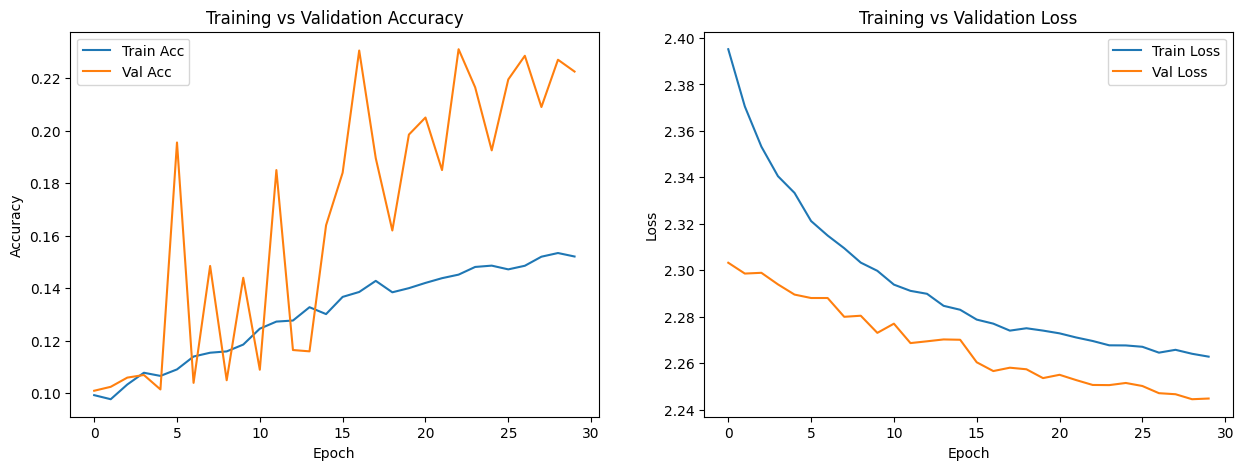

In [14]:
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Train Acc')
plt.plot(history_df['val_accuracy'], label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()


**Confusion Matrix.**

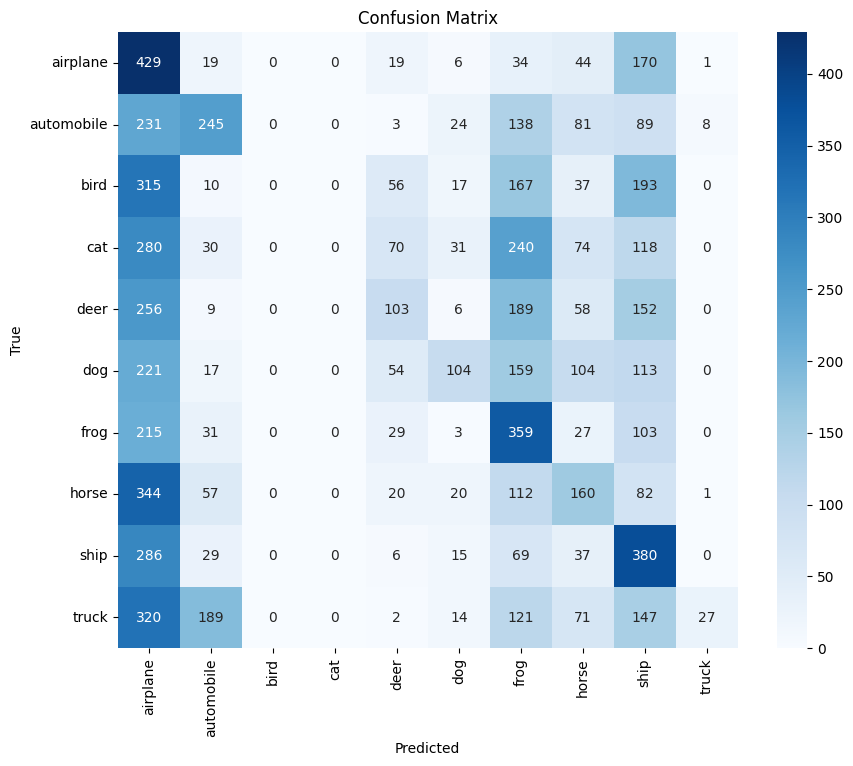

In [15]:
from sklearn.metrics import confusion_matrix

y_true, y_pred = [], []
for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.15      0.59      0.24       722
  automobile       0.39      0.30      0.34       819
        bird       0.00      0.00      0.00       795
         cat       0.00      0.00      0.00       843
        deer       0.28      0.13      0.18       773
         dog       0.43      0.13      0.21       772
        frog       0.23      0.47      0.30       767
       horse       0.23      0.20      0.21       796
        ship       0.25      0.46      0.32       822
       truck       0.73      0.03      0.06       891

    accuracy                           0.23      8000
   macro avg       0.27      0.23      0.19      8000
weighted avg       0.27      0.23      0.18      8000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##Fine-Tuning Step.

**Fine-tune top layers**

In [17]:
base_model.trainable = True
fine_tune_at = 100  # freeze layers before this index
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [18]:
# Compile again with a low learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [19]:
# Continue training
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_dataset,
    callbacks=[reduce_lr, checkpoint, early_stop]
)

Epoch 30/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.2296 - loss: 2.1345
Epoch 30: val_loss did not improve from 2.24451
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 148s 107ms/step - accuracy: 0.2297 - loss: 2.1345 - val_accuracy: 0.1010 - val_loss: 5.7338 - learning_rate: 1.0000e-05
Epoch 31/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3296 - loss: 1.8835
Epoch 31: val_loss did not improve from 2.24451
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 134s 106ms/step - accuracy: 0.3296 - loss: 1.8835 - val_accuracy: 0.1195 - val_loss: 3.0825 - learning_rate: 1.0000e-05
Epoch 32/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.3516 - loss: 1.8194
Epoch 32: val_loss did not improve from 2.24451
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 133s 106ms/step - accuracy: 0.3516 - loss: 1.8193 - val_accuracy: 0.0990 - val_loss: 3.2520 - learning_rate: 1.0000e-05
Epoch 33/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3695 - loss: 1.7687
Epoch 33: val_loss did not improve from 2